# Function/Class Definitions & Setup

## Constants

In [1]:
DATA_DIR = './data/raw' # Where all the raw stories are
TRAIN_FILE = './data/train.jsonl'
TEST_FILE = './data/test.jsonl'
CORPUS_FILE = 'corpus.txt' # Where all the raw data will be stored

TOKENIZER_PREFIX = 'bpe_model' # Tokenizer name
TOKENIZER_PATH = TOKENIZER_PREFIX + ".model"
EOS_TOKEN = "<EOS>"
BOS_TOKEN = "<BOS>"
BOS_TOKEN_ID = 1
EOS_TOKEN_ID = 2
PAD_TOKEN_ID = 3

VOCAB_SIZE = 10000 # Based on project handout, limit of vocab tokens allowed
MAX_TRAIN_SEQ_LEN = 128
MAX_GEN_SEQ_LEN = 200


#MODIFIABLE CONSTANTS FOR MODEL TRAINING START HERE
DEVICE = "cuda"

BATCH_SIZE = 128
EPOCHS = 2
LEARNING_RATE = .002
# Dictates creativity of the model, < 1 more deterministic, > 1 more creative/stochastic, 1 is no change from base model.
TEMPERATURE = .9
EARLY_EPOCH_STOP = 4
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 3
DROPOUT = .2
N_HEADS = 8

## Main Helper

In [ ]:
from FinalProjHelper import *
import torch
import torch.nn as nn
from tqdm import tqdm
import sentencepiece as spm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
 
# Load the pre-trained tokenizer from the .model tokenizer file
def load_tokenizer(tokenizer_path):
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(tokenizer_path)
    return tokenizer


def collate_fn(batch):
    """ 
    This function takes in all of the batches from the dataset, which will be jagged arrays, and
    inserts padding tokens <pad> such that all of the sequences are the same length. Note that the
    Cross Entropy Loss criterion should specify to ignore the index 3 so it does not affect the training.

    :param batch: The batch of prompts and completions that form a jagged array to be padded.
    :return: The input and label batches properly padded.
    """

    enc_input_batch, dec_input_batch, target_batch = zip(*batch)
    enc_input_batch = nn.utils.rnn.pad_sequence(enc_input_batch, batch_first=True, padding_value=PAD_TOKEN_ID)
    dec_input_batch = nn.utils.rnn.pad_sequence(dec_input_batch, batch_first=True, padding_value=PAD_TOKEN_ID)
    target_batch = nn.utils.rnn.pad_sequence(target_batch, batch_first=True, padding_value=PAD_TOKEN_ID)
    return enc_input_batch, dec_input_batch, target_batch

def train_model(model, device, tokenizer, model_type=""):
    """ 
    The main training code generalized for all of the models,
    including evaluation metrics such as loss graphs, BLEU score, and Perplexity score.

    :param model: The instantiated model needing training.
    :param device: The device the model should be trained on, preferrably cuda.
    :param tokenizer: The loaded tokenizer trained on the dataset being used for model training.
    :return: The progression of training and testing losses.
    """
    # Loading tokenizer file and getting most up to date vocab size
    vocab_size = tokenizer.get_piece_size()

    # Set up datasets from the given jsonl files for training
    train_data = TextDatasetTED(TRAIN_FILE, tokenizer, MAX_TRAIN_SEQ_LEN)
    test_data = TextDatasetTED(TEST_FILE, tokenizer, MAX_TRAIN_SEQ_LEN)

    # Using pytorch DataLoaders for easy batching, shuffling, etc.
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # Adding on a decaying learning rate to the optimizer
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN_ID)

    best_test_loss = float('inf')
    no_improve_epochs = 0

    train_losses, test_losses = [], []
    for epoch in range(EPOCHS):
        #Emptying cache and unused data on every epoch since CUDA would run out of memory otherwise
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

        #Want the model in training mode
        model.train()
        total_train_loss = 0

        for enc_input_ids, dec_input_ids, target_ids in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            enc_input_ids = enc_input_ids.to(device)
            dec_input_ids = dec_input_ids.to(device)
            target_ids = target_ids.to(device)

            optimizer.zero_grad()

            # Get the padding masks for proper training
            enc_pad_mask = (enc_input_ids == PAD_TOKEN_ID)
            dec_pad_mask = (dec_input_ids == PAD_TOKEN_ID)

            # Getting the probability distributions for the prompts...
            logits = model(enc_input_ids, dec_input_ids, enc_pad_mask, dec_pad_mask)

            """
            For understanding this dimension change, understand that the logits are of
            dimension (B,S,V) (see forward() function of base model for explanantion) and the targets are of
            dimension (B,S) (where each entry is the correct token to predict for that position in the sequence).

            For Cross Entropy Loss, we must have 1 prediction for each row in both tensors. Therefore, if we can reduce
            each tensor such that it reads the last dimension for each row, the function will work. Aka we would have
            dimension (B x S, V) (every row is a token's probability distribution) and
            dimension (B x S) (every entry is that token's correct value, in chronological order with the logits)

            The .view() function allows us to do this my making the last dimension of each tensor account for each entry.
            """
            loss = criterion(logits.view(-1, vocab_size), target_ids.view(-1))

            # Adjusting weights...
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Don't want the model to train on testing data, so .eval()
        model.eval()
        total_test_loss = 0

        # Evaluate testing loss after training on this epoch to see performance on new data
        with torch.no_grad():
            for enc_input_ids, dec_input_ids, target_ids in test_loader:
                enc_input_ids = enc_input_ids.to(device)
                dec_input_ids = dec_input_ids.to(device)
                target_ids = target_ids.to(device)

                # Get the padding masks for proper training
                enc_pad_mask = (enc_input_ids == PAD_TOKEN_ID)
                dec_pad_mask = (dec_input_ids == PAD_TOKEN_ID)

                # Getting the probability distributions for the prompts...
                logits = model(enc_input_ids, dec_input_ids, enc_pad_mask, dec_pad_mask)

                loss = criterion(logits.view(-1, vocab_size), target_ids.view(-1))
                total_test_loss += loss.item()
            
            avg_test_loss = total_test_loss / len(test_loader)
            test_losses.append(avg_test_loss)
            scheduler.step(avg_test_loss)

            # If our testing data starts getting worse over time, we can stop it early to reduce losses in accuracy based on a preset constant
            if(avg_test_loss < best_test_loss):
                best_test_loss = avg_test_loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                
        if(no_improve_epochs >= EARLY_EPOCH_STOP):
            print(f"No improvement in {EARLY_EPOCH_STOP} epochs, stopping...")
            break

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Test Loss={avg_test_loss:.4f}")
    print(f"Model Perplexity: {Perplexity(avg_train_loss):.4f} Model BLEU: {BLEU(model, tokenizer, test_loader):.4f}")
    plotLossOverEpochs(EPOCHS, train_losses, test_losses, model_type)

    return train_losses, test_losses

def plotLossOverEpochs(epochs, train_loss, test_loss, model_type=""):
        """
        Creates a plot showing the losses over time for a model.

        :param epochs: The number of epochs the training took place over
        :param train_loss: The losses of training over the epochs
        :param test_loss: The losses of testing over the epochs
        :param name: The name of the trained model being evaluated
        """
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(model_type + " Loss per Epoch")

        x_range = range(1, epochs + 1)

        plt.plot(x_range, train_loss)
        plt.plot(x_range, test_loss)

        plt.plot(x_range, train_loss, label="Training Loss", color='blue')
        plt.plot(x_range, test_loss, label="Testing Loss", color='orange')

        plt.legend()
        plt.show()

#Because the loss is already cross entropy, we can just do the natural exponentiation of the loss
#Loss here is the average loss across tokens
def Perplexity(loss):
    return math.exp(loss)

def BLEU(model, tokenizer, test_loader):
    """
        Evaluates BLEU score of the entire model by getting probabilities.

        :param epochs: The number of epochs the training took place over
        :param train_loss: The losses of training over the epochs
        :param test_loss: The losses of testing over the epochs
        :param name: The name of the trained model being evaluated
        :return: The overall BLEU scoring of the prompts and completions ran on
    """

    model.eval()
    references = []
    candidates = []
    samples_processed = 0
    smoothing_function = SmoothingFunction().method1

    with torch.no_grad():
        
        # We really just want the raw prompts and completions to get rid of unnecessary padding
        for enc_input_ids, dec_input_ids, target_ids in test_loader:

            enc_input_ids = enc_input_ids.to(DEVICE)
            dec_input_ids = dec_input_ids.to(DEVICE)
            target_ids = target_ids.to(DEVICE)
            
            # Get the padding masks for proper training
            enc_pad_mask = (enc_input_ids == PAD_TOKEN_ID)
            dec_pad_mask = (dec_input_ids == PAD_TOKEN_ID)

            # The model does teacher forcing predictions, which is exactly what we need to compare with the labels
            logits = model(enc_input_ids, dec_input_ids, enc_pad_mask, dec_pad_mask)
            
            # Taking the best token from each probability distribution for comparison against the labels
            predicted_ids = torch.argmax(logits, dim=-1).cpu().tolist()
            target_ids = target_ids.cpu().tolist()

            for predicted, target in zip(predicted_ids, target_ids):

                # Process 250 samples so it doesnt run forever
                if samples_processed > 250:
                    break

                # For each prediction vector and label vector, decode it and add it to a list for BLEU scoring
                pred_decode = tokenizer.decode(predicted, out_type=str)
                reference = tokenizer.decode(target, out_type=str)

                samples_processed += 1
                
                candidates.append(pred_decode.split())
                references.append([reference.split()])
    
    # Compute the corpus-level BLEU score. For the purposes of this project, up to 3-gram comparisons were made
    bleu_score = corpus_bleu(references, candidates, weights=(.25, .25, .25, .25), smoothing_function=smoothing_function)
    return bleu_score

def prompt_model(model, tokenizer, name):
    while(1):
        print("Prompt " + name + " (type q to quit): ")
        prompt = input()
        if prompt.lower() == "q":
            break
        else:
            print(f"Your unit test: " + model.generate(tokenizer, 
                                                       prompt, 
                                                       max_seq_length=MAX_GEN_SEQ_LEN,
                                                       bos_token_id=BOS_TOKEN_ID, 
                                                       eos_token_id=EOS_TOKEN_ID, 
                                                       pad_token_id=PAD_TOKEN_ID,
                                                       temperature=TEMPERATURE,
                                                       device=DEVICE
                                                      ))



# Main Code

### Tokenizer & Preliminary Vars

In [3]:
run_spm = input("Train new tokenizer (needed if no .model file in project root)? (y/n): ").lower() == "y"
if run_spm:
    merge_text_files(DATA_DIR, CORPUS_FILE)

    spm.SentencePieceTrainer.train(
        input=CORPUS_FILE,
        model_prefix=TOKENIZER_PREFIX,
        vocab_size=VOCAB_SIZE,
        bos_id=BOS_TOKEN_ID, # Not starting at 0 because that is <unk>.
        eos_id=EOS_TOKEN_ID, # The reason we set the ids this way is because we have manually defined new tokens in the training and
        pad_id=PAD_TOKEN_ID, # testing data, so we must specify for the tokenizer training what these tokens are.
        user_defined_symbols=",".join(["<bos>", "<eos>", "<pad>"])
    )

device = torch.device(DEVICE)
tokenizer = load_tokenizer(TOKENIZER_PATH)

### Transformer ED

#### Training

Epoch 1/2:   0%|          | 0/310 [00:00<?, ?it/s]c:\Users\joshm\miniconda3\envs\AI_Foundation_Proj2\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Epoch 1/2: 100%|██████████| 310/310 [01:36<00:00,  3.23it/s]
c:\Users\joshm\miniconda3\envs\AI_Foundation_Proj2\Lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(
Epoch 2/2: 100%|██████████| 310/310 [01:19<00:00,  3.92it/s]


Epoch 2: Train Loss=3.8464, Test Loss=3.9627
Model Perplexity: 46.8255 Model BLEU: 0.0000


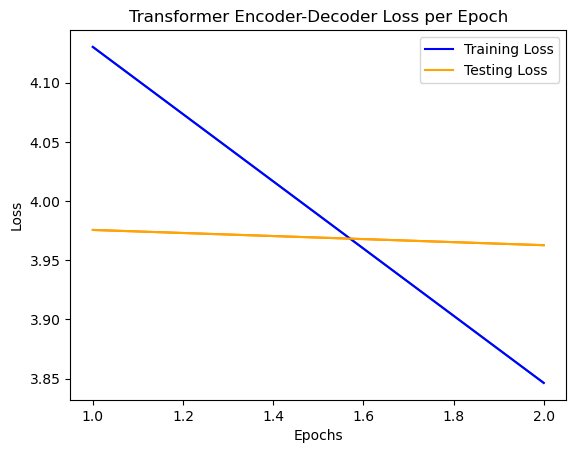

([4.130098939711048, 3.846428308948394],
 [3.975584176870493, 3.9627036926073904])

In [4]:
from FinalProjModels import TransformerEDLanguageModel

transformer_model = TransformerEDLanguageModel(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    enc_num_layers=NUM_LAYERS,
    dec_num_layers=NUM_LAYERS,
    n_heads=N_HEADS,
    dropout=DROPOUT,
    pad_token_id=PAD_TOKEN_ID,
    name="Transformer Encoder-Decoder"
).to(device)

train_model(transformer_model, device, tokenizer, transformer_model.name)

#### Prompting

In [5]:
prompt_model(transformer_model, tokenizer, transformer_model.name)

Prompt Transformer Encoder-Decoder (type q to quit): 
